***

# MLP
 - 사용자와 아이템에 대한 교호작용을 추정하고 이에 대하여 DNN 네트워크를 통해 선호 여부를 예측하는 기법
 
### - Reference: [Neural Collaborative Filtering](https://arxiv.org/pdf/1708.05031.pdf)

### - Prediction:
선호여부 $y_{ui}$에 대해서 아래와 같이 잠재 요인 행렬 P, Q와 DNN 네트워크의 결합을 통해 예측
<center> $\hat{y_{ui}}=\sigma(h^T\phi_{MLP})$ </center>

|expression|mean|
|:---:|:---:|
|$\phi_{MLP}$|$$a_L(W^T_L(a_{L-1}(...(a_2(W^T_2(p_u^T,q_u^T)^T+b_2)...))+b_L)$$|
|$ y_{ui}$|사용자 $u$의 아이템 $i$에 대한 선호 여부|
|$ p_u$| 사용자의 잠재요인 행렬 $P_{n*k}$의 $u$번째 열벡터|
|$q_i$|아이템의 잠재요인 행렬 $Q_{m*k}$의 $i$번째 열벡터|
|$n$|사용자 수|
|$m$|아이템 수|
|$k$|잠재 요인 갯수|
|$h$|선형 벡터|
|$\sigma(\cdot)$|활성화 시그모이드 함수|
|$W_n$|n번째 fully connected layer|
|$a_n(\cdot)$|n번째 활성화 함수|

### - Optimization:
관측된 평점에 대해서, binary cross entropy를 최소화하는 P, Q, h, W의 가중치를 추정함.</br>
관측된 아이템과, 관측되지 않은 아이템(임의추출)에 대하여 가중치 학습을 진행함
    
### - Evaluation:
Hit Ratio : 관측되지 않은 아이템에 대하여 top-K 선호순위를 결정하고, 해당 순위 이내에 testset의 아이템이 존재하면 1, 그렇지 않으면 0을 할당하여 사용자들의 평균을 구함.

|split|measure|
|:---:|:---:|
|leave-one-out|Hit Ratio|

***

## 0) Import library

In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

from Generator.PointwiseGenerator import PointwiseGenerator
from Models.MLP import MLP

import pandas as pd
import numpy as np
import random
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

***

## 1) Data processing

### load data

In [2]:
ratings = pd.read_csv('../data/movie_lens/ratings.csv',
                      names=['user_id', 'item_id', 'rating', '_'],
                      skiprows=1).drop(columns=['_'])
ratings

,user_id,item_id,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


### convert id to index

In [3]:
user_ids = ratings['user_id'].unique().tolist()
item_ids = ratings['item_id'].unique().tolist()

num_user = len(user_ids)
num_item = len(item_ids)

id_to_index_user = {user_ids[i] :i for i in range(num_user)}
id_to_index_item = {item_ids[i] :i for i in range(num_item)}

ratings['user_id'] = ratings['user_id'].apply(lambda x: id_to_index_user[x])
ratings['item_id'] = ratings['item_id'].apply(lambda x: id_to_index_item[x])

ratings

,user_id,item_id,rating
0,0,0,4.0
1,0,1,4.0
2,0,2,4.0
3,0,3,5.0
4,0,4,5.0
...,...,...,...
100831,609,3120,4.0
100832,609,2035,5.0
100833,609,3121,5.0
100834,609,1392,5.0


### convert explicit feedback to implicit feedback

In [4]:
ratings['rating'] = 1
ratings

,user_id,item_id,rating
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
...,...,...,...
100831,609,3120,1
100832,609,2035,1
100833,609,3121,1
100834,609,1392,1


### split data

In [5]:
leave_k = 1
seed = 1234

test = ratings.groupby('user_id').sample(leave_k, random_state=seed)
train_ = ratings.loc[ratings.index.isin(test.index)==False]
validation = train_.groupby('user_id').sample(leave_k, random_state=seed)
train = train_.loc[train_.index.isin(validation.index) == False]

print(f"# of observation(train/val/test): {len(train)}, {len(validation)}, {len(test)}")

# of observation(train/val/test): 99616, 610, 610


### set config & get dataset from generator

In [12]:
class DatasetConfig:
    num_negative = 5
    between_negative = False
    batch = 512

dataset_config = DatasetConfig()

In [13]:
dataset = PointwiseGenerator(train_data=train,
                             n_user=num_user,
                             n_item=num_item,
                             config=dataset_config)

### see example data for a batch

In [14]:
train_loader = DataLoader(dataset, batch_size=2)
data1, data2, data3, _ = next(iter(train_loader))

(1) [user id X batch_size]

In [15]:
data1

tensor([0, 0])

(2) [item id X batch_size]

In [16]:
data2

tensor([   0, 6732])

(3) [ [rating] X batch_size]

In [17]:
data3

tensor([[1.],
        [0.]])

***

## 2) Modeling

### set config & get model

In [18]:
class OptimizerConfig:
    method = 'Adam'
    regulation = 1e-5
    learning_rate = 0.01
    learning_decay = 0.95

class ModelConfig:
    epochs = 30
    print_step = 5

class MLPConfig:
    evaluation = 'HR'
    dim_latent = 16
    k = 10
    sample = 100

optimizer_config = OptimizerConfig()
mlp_config = MLPConfig()
model_config = ModelConfig()

In [19]:
inputs = {"n_user":num_user,
          "n_item":num_item}

model = MLP(inputs, model_config, optimizer_config, mlp_config)

[BaseModel] method = Adam
[BaseModel] regulation = 1e-05
[BaseModel] learning_rate = 0.01
[BaseModel] learning_rate_decay = 0.95


### fit model & see loss and performance

In [20]:
train_loader = DataLoader(dataset, batch_size=dataset_config.batch)
model.fit(train_loader=train_loader, val_data=validation)


[MLP]============================================== Train ===============================================
[MLP]               (train: BCE)        (validation: HR)    
          (epoch 5) 0.3026              0.6885              
         (epoch 10) 0.2875              0.7426              
         (epoch 15) 0.2576              0.7754              
         (epoch 20) 0.2374              0.7656              
         (epoch 25) 0.2233              0.7967              
         (epoch 30) 0.2079              0.8049              


### save weight for NeuMF

In [21]:
weight = model.get_weight()
torch.save(weight, '../output/pretrained_mlp.pth')

***

## 3) Evaluation

### evaluate testset

In [22]:
model.test(train_loader=train_loader, test_data=test)


[MLP]============================================= Evaluate =============================================
[GMF] (test: HR) = 0.7984


### see plot for loss and performance

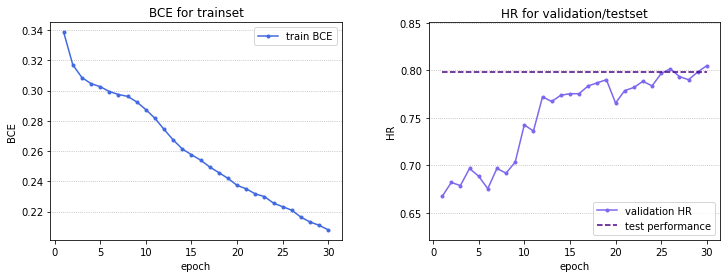

In [23]:
figure = model.draw_plot()
plt.show()